In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
import numpy as np
from scipy import ndimage
dir = './Train/Train/'

In [27]:
data = pd.read_csv('metadataTrain.csv')
data.head()

,ID,CLASS,SEX,AGE,POSITION
0,ISIC_0000000,2,female,55.0,anterior torso
1,ISIC_0000001,2,female,30.0,anterior torso
2,ISIC_0000002,1,female,60.0,upper extremity
3,ISIC_0000003,2,male,30.0,upper extremity
4,ISIC_0000004,1,male,80.0,posterior torso


In [28]:
nosex = data[(data['SEX'].isna())]
nosex_names = nosex['ID'].to_numpy()
nosex.head()

,ID,CLASS,SEX,AGE,POSITION
55,ISIC_0000080,2,NaN,NaN,NaN
56,ISIC_0000081,2,NaN,NaN,NaN
57,ISIC_0000086,2,NaN,NaN,NaN
58,ISIC_0000087,2,NaN,NaN,NaN
59,ISIC_0000088,2,NaN,NaN,NaN


In [29]:
print(len(nosex_names))

284


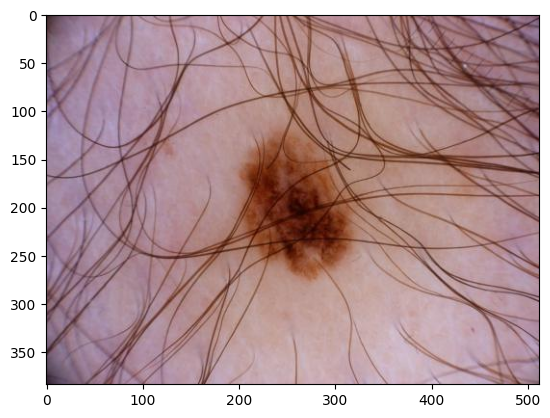

In [30]:
im = cv.cvtColor(cv.imread(dir+nosex_names[10]+'.jpg'),cv.COLOR_BGR2RGB)
plt.imshow(im)

In [31]:
print(im.shape)

(384, 512, 3)


In [32]:
im = im.reshape(-1,3)
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(im)
best_contrast = pca.transform(im)
print(best_contrast.shape)

(196608, 1)


In [33]:
print(pca.explained_variance_ratio_)

[0.94732094]


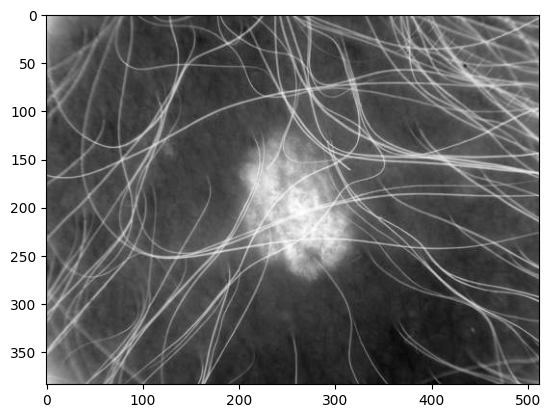

In [34]:
best_contrast = best_contrast.reshape(384,512)
plt.imshow(best_contrast,cmap='gray')


c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_signaltools.py:1629: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)


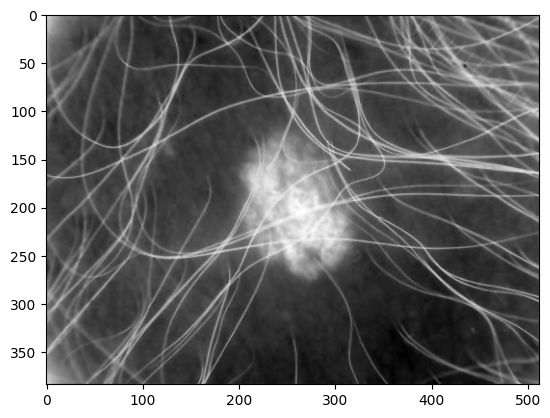

In [35]:
# Remove noise with Wiener filter
from scipy.signal import wiener
filter_im = wiener(best_contrast,(3,3))
plt.imshow(filter_im, cmap='gray')


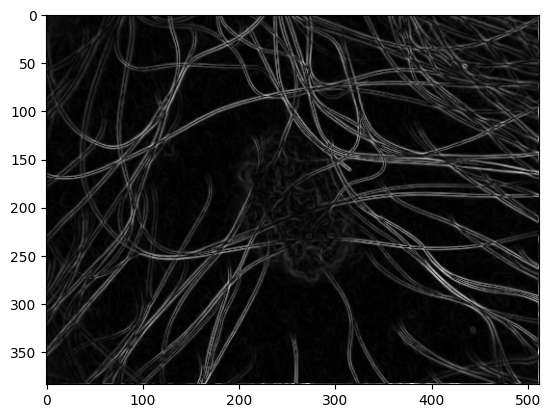

In [36]:
# Compute gradient with sobel filter
gx = ndimage.sobel(filter_im,axis=0,mode='wrap')
gy = ndimage.sobel(filter_im,axis=1,mode='wrap')
g = np.sqrt(gx**2+gy**2).astype(int)
plt.imshow(g,cmap='gray')

In [37]:
#Compute gradient direction and round it to four angles between horizontal, vertical and the two diagonals
theta = np.arctan2(gy,gx)
theta[theta<0]+=np.pi
n,m = theta.shape
for i in range(n):
    for j in range(m):
        t = theta[i,j]
        if t< np.pi/8:
            theta[i,j] = 0
        elif t<3*np.pi/8:
            theta[i,j] = np.pi/4
        elif t<5*np.pi/8:
            theta[i,j] = np.pi/2
        elif t<7*np.pi/8:
            theta[i,j] = 3*np.pi/4
        else:
            theta[i,j] = 0

In [38]:
#Perform non-maximum suppression
g[0,:] = 0
g[n-1,:] = 0
g[:,0] = 0
g[:,m-1] = 0

for i in range(1,n-1):
    for j in range(1,m-1):
        val = g[i,j]
        direc = theta[i,j]

        if direc == 0:
            if val<g[i,j-1] or val<g[i,j+1]:
                g[i,j] = 0
        elif direc == np.pi/4:
            if val<g[i-1,j+1] or val<g[i+1,j-1]:
                g[i,j] = 0
        elif direc == np.pi/2:
            if val<g[i-1,j] or val<g[i+1,j]:
                g[i,j] = 0
        elif direc == 3*np.pi/4:
            if val<g[i-1,j-1] or val<g[i+1,j+1]:
                g[i,j] = 0

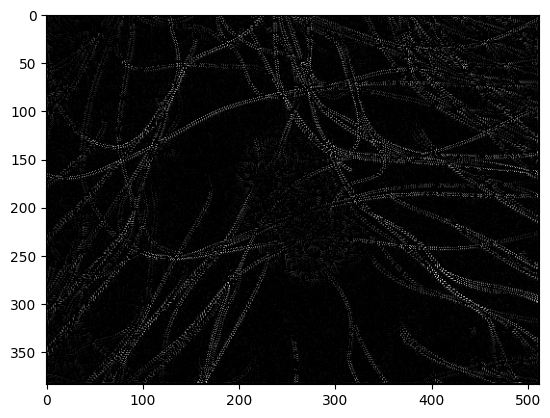

In [39]:
plt.imshow(g,cmap='gray')

In [40]:
print(g)

[[  0   0   0 ...   0   0   0]
 [  0  67  73 ...   0  81   0]
 [  0   0  68 ...   0   0   0]
 ...
 [  0   0   0 ...   0 114   0]
 [  0  30  49 ...  32   0   0]
 [  0   0   0 ...   0   0   0]]


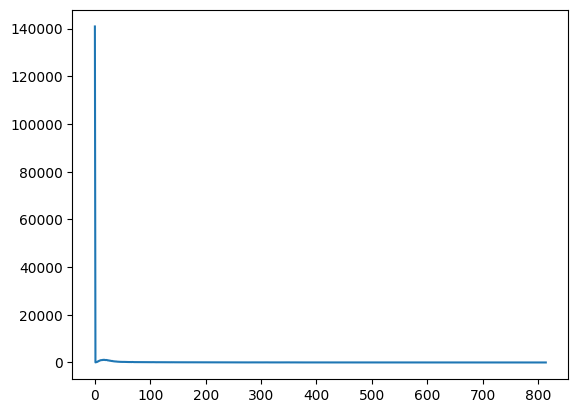

In [41]:
n = np.max(g)
h,bins = np.histogram(g,bins=n+1)
plt.plot(np.linspace(0,n,n+1),h)

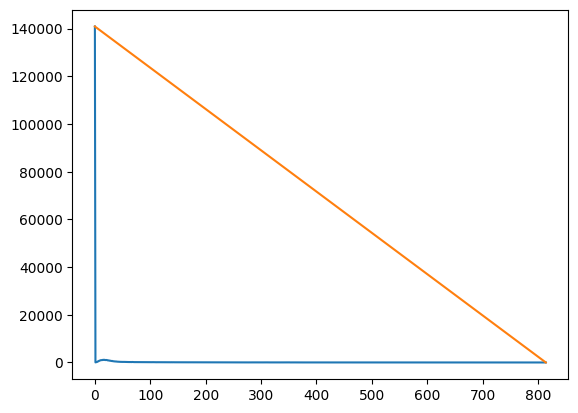

In [42]:
#Get convex hull of histogram an maximum concavity
hull = np.zeros(n+1)
k=0
hk=h[k]
npr = h.shape[0]
while k < npr-1 :
    tmax = np.NINF
    new_k = 0
    for i in range(k+1,npr):
        t = (h[i]-hk)/(i-k)
        if t >= tmax:
            tmax = t
            new_k = i
    hull[k:new_k] = np.linspace(k,new_k-1,new_k-k)*tmax+hk
    k = new_k
    hk = h[k]

plt.plot(np.linspace(0,n,n+1),h)
plt.plot(np.linspace(0,n,n+1),hull)
    


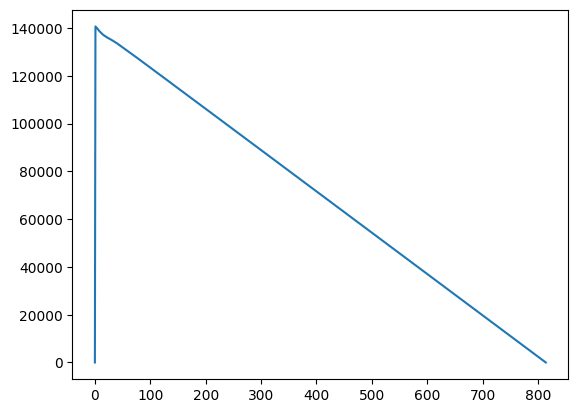

In [43]:
concavities = hull-h
plt.plot(np.linspace(0,n,n+1),concavities)

In [66]:
threshold = np.argmax(concavities)
print(threshold)

1


In [67]:
#Dual thresholding
n,m = g.shape
edge_strength = np.zeros(g.shape)
for i in range(n):
    for j in range(m):
        s = g[i,j]
        if s >= threshold:
            edge_strength[i,j] = 2
        elif s >= 0.4*threshold:
            edge_strength[i,j] = 1
        else :
            g[i,j] = 0

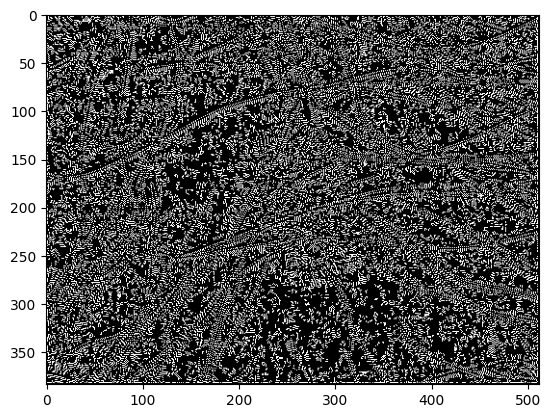

In [68]:
plt.imshow(edge_strength,cmap='gray')

In [69]:
#Edge tracking by hysteresis
def strong_neighbor(edge_strength,i,j):
    a,b = edge_strength.shape
    
    neighbors = np.array([[i-1,i-1,i-1,i,i+1,i+1,i+1,i],[j-1,j,j+1,j+1,j+1,j,j-1,j-1]])
    neighbors = np.delete(neighbors,np.where((neighbors[0]<0)|(neighbors[1]<0)|(neighbors[0]>=a)|(neighbors[1]>=b))[0],axis=1)
    neighbors = np.array([(x,y) for x,y in zip(neighbors[0,:],neighbors[1,:])])

    neighbors_strength = [edge_strength[x,y] for x,y in neighbors]

    return 2 in neighbors_strength

In [70]:
for i in range(n):
    for j in range(m):
        strength = edge_strength[i,j]
        if strength == 1:
            if strong_neighbor(edge_strength,i,j):
                edge_strength[i,j] = 2
            else:
                edge_strength[i,j] = 0
                g[i,j] = 0

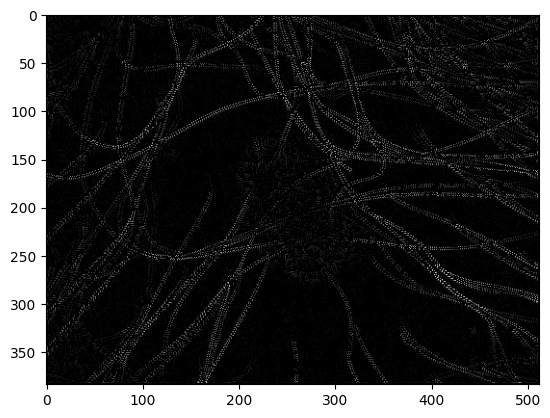

In [71]:
plt.imshow(g,cmap='gray')